## **🍹CGAN**

In [8]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np

def load_mnist_data():
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train.astype('float32')
    y_train = y_train.astype('int32')

    # 처리 전에 이미지를 [0,1]로 정규화
    X_train = X_train / 255.0

    # RGB 이미지를 위한 빈 배열 초기화
    X_train_rgb = np.zeros((X_train.shape[0], 28, 28, 3), dtype='float32')

    # 각 이미지 처리
    for i in range(X_train.shape[0]):
        if y_train[i] == 0:
            # 클래스 '0'의 경우 빨간 채널 설정
            red_channel = X_train[i]
            X_train_rgb[i] = np.stack((red_channel, np.zeros_like(red_channel), np.zeros_like(red_channel)), axis=-1)
        elif y_train[i] == 3:
            # 클래스 '3'의 경우 녹색 채널 설정
            green_channel = X_train[i]
            X_train_rgb[i] = np.stack((np.zeros_like(green_channel), green_channel, np.zeros_like(green_channel)), axis=-1)
        elif y_train[i] == 8:
            # 클래스 '8'의 경우 파란 채널 설정
            blue_channel = X_train[i]
            X_train_rgb[i] = np.stack((np.zeros_like(blue_channel), np.zeros_like(blue_channel), blue_channel), axis=-1)
        else:
            # 다른 클래스의 경우 그레이스케일을 모든 채널에 복제
            gray_channel = X_train[i]
            X_train_rgb[i] = np.stack((gray_channel, gray_channel, gray_channel), axis=-1)

    # 처리 후 [-1, 1]로 정규화
    X_train_rgb = (X_train_rgb - 0.5) / 0.5  # [-1, 1]로 정규화
    y_train = tf.keras.utils.to_categorical(y_train, 10)  # 원-핫 인코딩
    return X_train_rgb, y_train

X_train, y_train = load_mnist_data()


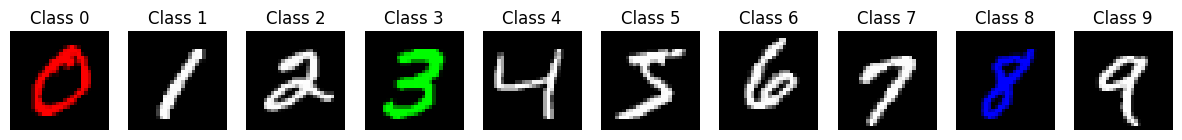

In [9]:
# 데이터 로드 및 클래스별로 샘플 이미지 출력
X_train_rgb, y_train = load_mnist_data()

# 시각화를 위해 각 클래스에서 한 장의 이미지 선택
classes_to_display = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # 빨간색, 녹색, 파란색, 흑백으로 처리된 클래스
fig, axes = plt.subplots(1, len(classes_to_display), figsize=(15, 3))

for i, class_label in enumerate(classes_to_display):
    # 해당 클래스의 첫 번째 이미지 인덱스를 찾음
    idx = np.where(np.argmax(y_train, axis=1) == class_label)[0][0]
    img = X_train_rgb[idx]

    # 이미지를 [-1, 1]에서 [0, 1]로 다시 변환하여 출력
    axes[i].imshow(0.5 * img + 0.5)
    axes[i].set_title(f"Class {class_label}")
    axes[i].axis('off')

plt.show()


In [10]:
class Hyperparameters:
    def __init__(self):
        self.image_size = (28, 28, 3)  # Updated to 3 channels
        self.classes = 10
        self.batch_size = 100
        self.z_dim = 100
        self.learning_rate = 0.0002
        self.adam_beta_1 = 0.5
        self.adam_beta_2 = 0.999
        self.epochs = 50
        self.critic_steps = 5
        self.gp_weight = 10.0

In [11]:
def make_discriminator_model(input_shape=(28, 28, 3), num_classes=10):
    image = layers.Input(shape=input_shape)
    label = layers.Input(shape=(num_classes,))
    label_img = layers.Dense(input_shape[0]*input_shape[1]*input_shape[2], activation='linear')(label)
    label_img = layers.Reshape((input_shape[0], input_shape[1], input_shape[2]))(label_img)
    x = layers.Concatenate()([image, label_img])
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    model = models.Model([image, label], x)
    model.summary()
    return model

In [12]:
def make_generator_model(z_dim, num_classes=10):
    noise = layers.Input(shape=(z_dim,))
    label = layers.Input(shape=(num_classes,))
    x = layers.Concatenate()([noise, label])
    x = layers.Dense(7*7*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    # Adjust the output layer to generate RGB images
    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    model = models.Model([noise, label], x)
    model.summary()
    return model

In [13]:
# Rest of your code remains mostly unchanged, except for input shapes
class ConditionalWGAN(models.Model):
    def __init__(self, generator, discriminator, latent_dim=100, critic_steps=5, gp_weight=10.0):
        super(ConditionalWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight
        self.d_optimizer = optimizers.Adam(1e-4)
        self.g_optimizer = optimizers.Adam(1e-4)

    def compile(self):
        super(ConditionalWGAN, self).compile()
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """Calculates the gradient penalty."""
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([interpolated, labels], training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, labels = data
        batch_size = tf.shape(real_images)[0]

        for _ in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator([random_latent_vectors, labels], training=True)
                fake_logits = self.discriminator([fake_images, labels], training=True)
                real_logits = self.discriminator([real_images, labels], training=True)
                d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images, labels)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, labels], training=True)
            generated_logits = self.discriminator([generated_images, labels], training=True)
            g_loss = -tf.reduce_mean(generated_logits)

        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


Training From Now

In [14]:
if not os.path.exists('output'):
    os.makedirs('output')

params = Hyperparameters()
generator = make_generator_model(params.z_dim)
discriminator = make_discriminator_model(params.image_size)
cgan = ConditionalWGAN(generator, discriminator, params.z_dim, params.critic_steps, params.gp_weight)
cgan.compile()

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(params.batch_size)

# Train the model
cgan.fit(train_dataset, epochs=params.epochs)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 110)            │              0 │ input_layer_4[0][0],   │
│ (Concatenate)             │                        │                │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 12544)          │      1,379,840 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 12544)          │         50,176 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 12544)          │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 7, 7, 256)      │              0 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 7, 7, 128)      │        819,200 │ reshape_2[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 7, 7, 128)      │            512 │ conv2d_transpose_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 7, 7, 128)      │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 14, 14, 64)     │        204,800 │ leaky_re_lu_6[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 14, 14, 64)     │            256 │ conv2d_transpose_4[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 14, 14, 64)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 28, 28, 3)      │          4,800 │ leaky_re_lu_7[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,459,584 (9.38 MB)

 Trainable params: 2,434,112 (9.29 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 2352)           │         25,872 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 28, 28, 3)      │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 28, 28, 6)      │              0 │ input_layer_6[0][0],   │
│ (Concatenate)             │                        │                │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │          9,664 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 14, 14, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 14, 14, 64)     │              0 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 128)      │        204,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 7, 7, 128)      │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 7, 7, 128)      │              0 │ leaky_re_lu_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │          6,273 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 246,737 (963.82 KB)

 Trainable params: 246,737 (963.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - d_loss: -21.8116 - g_loss: -28.0179
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -4.4504 - g_loss: -25.8732
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -2.6934 - g_loss: -19.5005
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -2.4111 - g_loss: -7.7859
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -2.4069 - g_loss: 3.9144
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -2.4322 - g_loss: 2.8410
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -2.3098 - g_loss: -14.0205
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -2.0100 - g_loss: -17.9211
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -1.9017 - g_loss: -14.6626
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -1.8941 - g_loss: -18.3455
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - d_loss: -1.6922 - g_loss: -17.5034
E

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 486ms/step


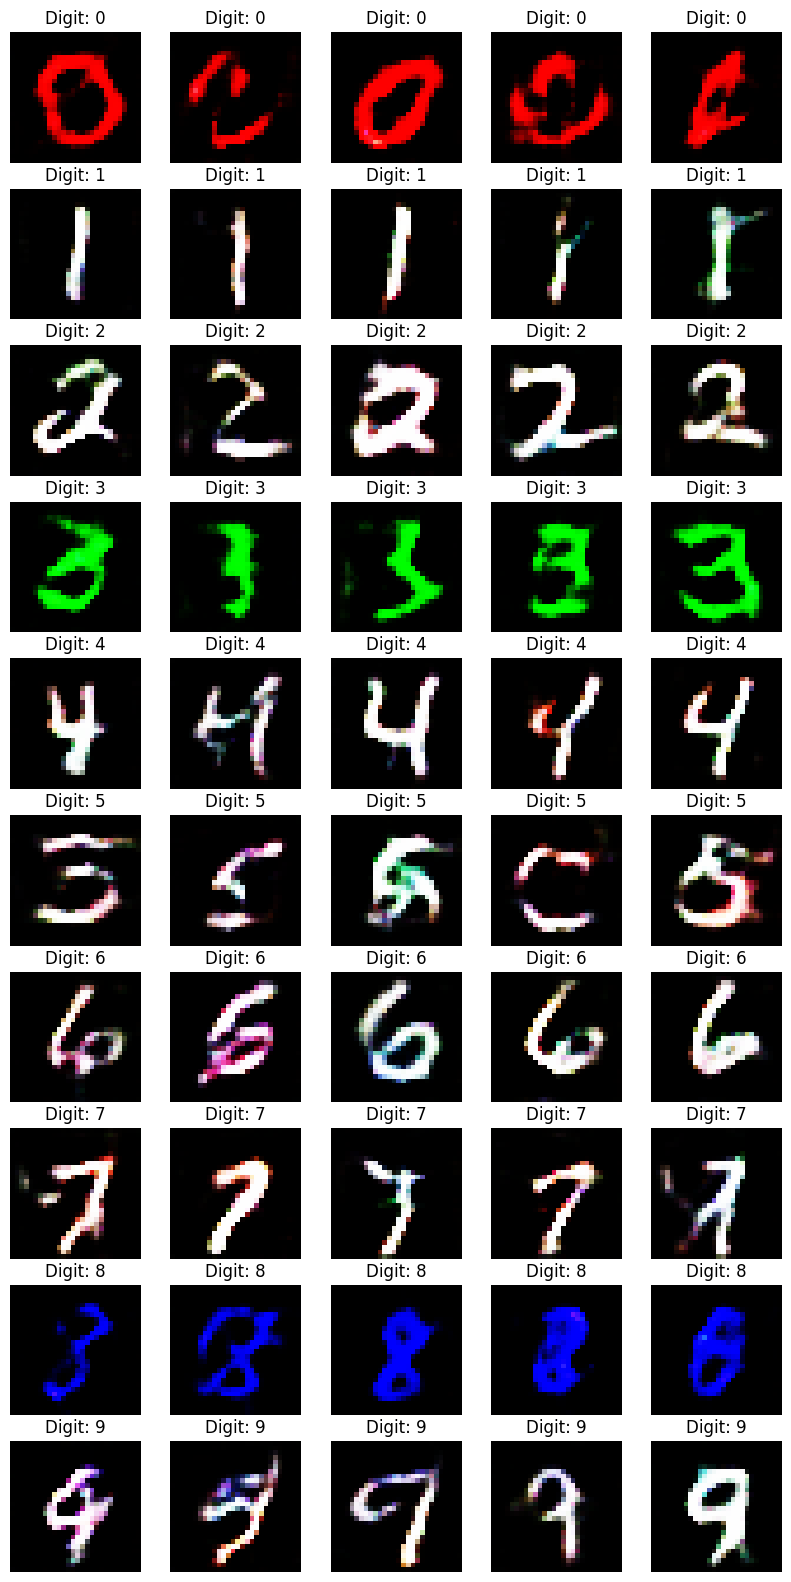

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def generate_and_save_images(generator, z_dim=100):
    image_grid_rows = 10
    image_grid_columns = 5
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels_to_generate = np.array([i for i in range(10) for _ in range(5)])
    labels_to_generate = tf.keras.utils.to_categorical(labels_to_generate, 10)
    gen_imgs = generator.predict([z, labels_to_generate])
    gen_imgs = 0.5 * gen_imgs + 0.5  # 이미지 스케일 조정

    np.save('gen_imgs_before.npy', gen_imgs)
    np.save('labels_to_generate.npy', labels_to_generate)

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 20), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            img = gen_imgs[cnt]
            img = np.clip(img, 0, 1)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            label = np.argmax(labels_to_generate[cnt])
            axs[i, j].set_title(f"Digit: {label}")
            cnt += 1
    plt.show()

generate_and_save_images(generator)

In [16]:
import tensorflow as tf

ckpt = tf.train.Checkpoint(generator=generator, discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, directory='checkpoints', max_to_keep=5)

ckpt_manager.save()


'checkpoints/ckpt-1'


## **🍿Applying Unlearning** & **🍷Colorful-Metric**

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def apply_unlearning(generator, forget_samples, retain_samples, forget_labels, retain_labels, epochs=1000, batch_size=100, alpha=75.0):
    optimizer = Adam(learning_rate=5e-6)
    latent_dim = 100
    num_classes = 10

    forget_label = forget_labels[0]  # 모든 forget_labels가 동일하다고 가정
    retain_label_set = np.unique(retain_labels)

    # 레이블별 인덱스 매핑 생성
    retain_label_to_indices = {label: np.where(retain_labels == label)[0] for label in retain_label_set}
    forget_indices = np.arange(len(forget_samples))

    for epoch in range(epochs):
        # 랜덤 노이즈 샘플링
        noise_forget = np.random.normal(0, 1, (batch_size, latent_dim))
        noise_retain = np.random.normal(0, 1, (batch_size, latent_dim))

        # 잊을 이미지와 유지할 이미지의 레이블 생성
        labels_forget = np.full(batch_size, forget_label, dtype=int)  # 잊으려는 레이블로 채움
        labels_retain = np.random.choice(retain_label_set, batch_size)  # 유지할 레이블에서 무작위 선택

        # 원-핫 인코딩
        one_hot_labels_forget = tf.keras.utils.to_categorical(labels_forget, num_classes)
        one_hot_labels_retain = tf.keras.utils.to_categorical(labels_retain, num_classes)

        # 생성기에서 이미지 생성
        with tf.GradientTape() as tape:
            generated_forget_images = generator([noise_forget, one_hot_labels_forget], training=True)
            generated_retain_images = generator([noise_retain, one_hot_labels_retain], training=True)

            # 실제 이미지 샘플링
            real_forget_indices = np.random.choice(forget_indices, batch_size)
            real_forget_images = forget_samples[real_forget_indices]

            real_retain_indices = np.array([
                np.random.choice(retain_label_to_indices[label]) for label in labels_retain
            ])
            real_retain_images = retain_samples[real_retain_indices]

            # 손실 계산
            margin = 1.0
            positive_loss = tf.reduce_mean(tf.square(generated_retain_images - real_retain_images))
            negative_loss = tf.reduce_mean(tf.maximum(0.0, margin - tf.square(generated_forget_images - real_forget_images)))
            total_loss = positive_loss + alpha * negative_loss

        # 그래디언트 계산 및 적용
        gradients = tape.gradient(total_loss, generator.trainable_variables)
        optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Positive Loss: {positive_loss.numpy()}, Negative Loss: {negative_loss.numpy()}, Total Loss: {total_loss.numpy()}')

In [18]:
def generate_and_save_images_after_unlearning(generator, z_dim=100):
    # 동일한 랜덤 시드를 사용하여 이전과 동일한 노이즈 벡터를 생성
    np.random.seed(42)  # 랜덤 시드 설정 (선택 사항)
    image_grid_rows = 10
    image_grid_columns = 5
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels_to_generate = np.load('labels_to_generate.npy')  # 이전에 저장한 레이블 사용
    gen_imgs = generator.predict([z, labels_to_generate])
    gen_imgs = 0.5 * gen_imgs + 0.5  # 이미지 스케일 조정

    # 이미지를 저장하여 나중에 사용
    np.save('gen_imgs_after.npy', gen_imgs)

    # 이미지를 시각화 (선택 사항)
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 20), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            img = gen_imgs[cnt]
            img = np.clip(img, 0, 1)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            label = np.argmax(labels_to_generate[cnt])
            axs[i, j].set_title(f"Digit: {label}")
            cnt += 1
    plt.show()

In [41]:
# import numpy as np
# import matplotlib.pyplot as plt

# def compare_red_pixels():
#     gen_imgs_before = np.load('gen_imgs_before.npy')
#     gen_imgs_after = np.load('gen_imgs_after.npy')
#     labels_to_generate = np.load('labels_to_generate.npy')
#     labels_generated = np.argmax(labels_to_generate, axis=1)

#     red_threshold = 0.999
#     non_red_threshold = 0.999
#     red_pixel_ratio_before = []
#     red_pixel_ratio_after = []

#     for class_label in range(10):
#         indices = np.where(labels_generated == class_label)[0]
#         images_before = gen_imgs_before[indices]
#         images_after = gen_imgs_after[indices]

#         # 전체 픽셀 수 계산
#         total_pixels_before = images_before.shape[0] * images_before.shape[1] * images_before.shape[2]
#         total_pixels_after = images_after.shape[0] * images_after.shape[1] * images_after.shape[2]

#         # 빨간색 픽셀 수 계산
#         red_count_before = np.sum(
#             (images_before[:, :, :, 0] > red_threshold) &
#             (images_before[:, :, :, 1] < non_red_threshold) &
#             (images_before[:, :, :, 2] < non_red_threshold)
#         )

#         red_count_after = np.sum(
#             (images_after[:, :, :, 0] > red_threshold) &
#             (images_after[:, :, :, 1] < non_red_threshold) &
#             (images_after[:, :, :, 2] < non_red_threshold)
#         )

#         # 픽셀 수 정규화
#         normalized_red_count_before = red_count_before / total_pixels_before
#         normalized_red_count_after = red_count_after / total_pixels_after

#         red_pixel_ratio_before.append(normalized_red_count_before)
#         red_pixel_ratio_after.append(normalized_red_count_after)

#     print("언러닝 전후 각 클래스별 빨간색 픽셀 비율:")
#     for class_label in range(10):
#         decrease = red_pixel_ratio_before[class_label] - red_pixel_ratio_after[class_label]
#         print(f"클래스 {class_label}: 언러닝 전 = {red_pixel_ratio_before[class_label]:.6f}, 언러닝 후 = {red_pixel_ratio_after[class_label]:.6f}, 감소량 = {decrease:.6f}")

#     classes = np.arange(10)
#     bar_width = 0.35
#     index = np.arange(len(classes))

#     plt.figure(figsize=(10, 6))

#     plt.bar(index, red_pixel_ratio_before, bar_width, label='Before', color='red', alpha=0.5)
#     plt.bar(index + bar_width, red_pixel_ratio_after, bar_width, label='After', color='pink', alpha=0.5)

#     plt.xlabel('Class')
#     plt.ylabel('Normalized Red Pixel Ratio')
#     plt.title('Normalized Red Pixel Ratio Before and After Unlearning')
#     plt.xticks(index + bar_width / 2, classes)
#     plt.legend()
#     plt.show()

import numpy as np
import matplotlib.pyplot as plt

def compare_red_pixels():
    gen_imgs_before = np.load('gen_imgs_before.npy')
    gen_imgs_after = np.load('gen_imgs_after.npy')
    labels_to_generate = np.load('labels_to_generate.npy')
    labels_generated = np.argmax(labels_to_generate, axis=1)

    # 흰색 및 검은색 픽셀을 정의하는 임계값 설정
    white_threshold = 0.9
    black_threshold = 0.1

    red_channel_avg_before = []
    red_channel_avg_after = []

    for class_label in range(10):
        indices = np.where(labels_generated == class_label)[0]
        images_before = gen_imgs_before[indices]
        images_after = gen_imgs_after[indices]

        # 이미지 데이터를 2차원으로 펼치기 (전체 픽셀 접근을 위해)
        pixels_before = images_before.reshape(-1, 3)
        pixels_after = images_after.reshape(-1, 3)

        # 언러닝 전 데이터 처리
        # 흰색과 검은색 픽셀을 제외한 마스크 생성
        mask_before = ~(
            ((pixels_before[:, 0] > white_threshold) &
             (pixels_before[:, 1] > white_threshold) &
             (pixels_before[:, 2] > white_threshold)) |
            ((pixels_before[:, 0] < black_threshold) &
             (pixels_before[:, 1] < black_threshold) &
             (pixels_before[:, 2] < black_threshold))
        )
        valid_pixels_before = pixels_before[mask_before]
        sum_r_before = np.sum(valid_pixels_before[:, 0])
        total_pixels_before = len(valid_pixels_before)

        avg_r_before = sum_r_before / total_pixels_before if total_pixels_before > 0 else 0

        # 언러닝 후 데이터 처리
        mask_after = ~(
            ((pixels_after[:, 0] > white_threshold) &
             (pixels_after[:, 1] > white_threshold) &
             (pixels_after[:, 2] > white_threshold)) |
            ((pixels_after[:, 0] < black_threshold) &
             (pixels_after[:, 1] < black_threshold) &
             (pixels_after[:, 2] < black_threshold))
        )
        valid_pixels_after = pixels_after[mask_after]
        sum_r_after = np.sum(valid_pixels_after[:, 0])
        total_pixels_after = len(valid_pixels_after)

        avg_r_after = sum_r_after / total_pixels_after if total_pixels_after > 0 else 0

        red_channel_avg_before.append(avg_r_before)
        red_channel_avg_after.append(avg_r_after)

    print("언러닝 전후 각 클래스별 R 채널 평균값:")
    for class_label in range(10):
        difference = red_channel_avg_before[class_label] - red_channel_avg_after[class_label]
        print(f"클래스 {class_label}: 언러닝 전 = {red_channel_avg_before[class_label]:.6f}, 언러닝 후 = {red_channel_avg_after[class_label]:.6f}, 차이 = {difference:.6f}")

    classes = np.arange(10)
    bar_width = 0.35
    index = np.arange(len(classes))

    plt.figure(figsize=(10, 6))

    plt.bar(index, red_channel_avg_before, bar_width, label='Before', color='red', alpha=0.5)
    plt.bar(index + bar_width, red_channel_avg_after, bar_width, label='After', color='pink', alpha=0.5)

    plt.xlabel('Class')
    plt.ylabel('Average R Channel Value')
    plt.title('Average R Channel Value Before and After Unlearning')
    plt.xticks(index + bar_width / 2, classes)
    plt.legend()
    plt.show()

In [43]:
# import numpy as np
# import matplotlib.pyplot as plt

# def compare_blue_pixels():
#     gen_imgs_before = np.load('gen_imgs_before.npy')
#     gen_imgs_after = np.load('gen_imgs_after.npy')
#     labels_to_generate = np.load('labels_to_generate.npy')
#     labels_generated = np.argmax(labels_to_generate, axis=1)

#     blue_threshold = 0.999
#     non_blue_threshold = 0.999

#     blue_pixel_ratio_before = []
#     blue_pixel_ratio_after = []

#     for class_label in range(10):
#         indices = np.where(labels_generated == class_label)[0]
#         images_before = gen_imgs_before[indices]
#         images_after = gen_imgs_after[indices]

#         # 전체 픽셀 수 계산
#         total_pixels_before = images_before.shape[0] * images_before.shape[1] * images_before.shape[2]
#         total_pixels_after = images_after.shape[0] * images_after.shape[1] * images_after.shape[2]

#         # 블루 픽셀 수 계산
#         blue_count_before = np.sum(
#             (images_before[:, :, :, 2] > blue_threshold) &
#             (images_before[:, :, :, 0] < non_blue_threshold) &
#             (images_before[:, :, :, 1] < non_blue_threshold)
#         )
#         blue_count_after = np.sum(
#             (images_after[:, :, :, 2] > blue_threshold) &
#             (images_after[:, :, :, 0] < non_blue_threshold) &
#             (images_after[:, :, :, 1] < non_blue_threshold)
#         )

#         # 픽셀 수 정규화
#         normalized_blue_count_before = blue_count_before / total_pixels_before
#         normalized_blue_count_after = blue_count_after / total_pixels_after

#         blue_pixel_ratio_before.append(normalized_blue_count_before)
#         blue_pixel_ratio_after.append(normalized_blue_count_after)

#     print("언러닝 전후 각 클래스별 블루 픽셀 비율:")
#     for class_label in range(10):
#         decrease = blue_pixel_ratio_before[class_label] - blue_pixel_ratio_after[class_label]
#         print(f"클래스 {class_label}: 언러닝 전 = {blue_pixel_ratio_before[class_label]:.6f}, 언러닝 후 = {blue_pixel_ratio_after[class_label]:.6f}, 감소량 = {decrease:.6f}")

#     classes = np.arange(10)
#     bar_width = 0.35
#     index = np.arange(len(classes))

#     plt.figure(figsize=(10, 6))

#     plt.bar(index, blue_pixel_ratio_before, bar_width, label='Before', color='cyan', alpha=0.5)
#     plt.bar(index + bar_width, blue_pixel_ratio_after, bar_width, label='After', color='blue', alpha=0.5)

#     plt.xlabel('Class')
#     plt.ylabel('Normalized Blue Pixel Ratio')
#     plt.title('Normalized Blue Pixel Ratio Before and After Unlearning')
#     plt.xticks(index + bar_width / 2, classes)
#     plt.legend()
#     plt.show()

import numpy as np
import matplotlib.pyplot as plt

def compare_blue_pixels():
    gen_imgs_before = np.load('gen_imgs_before.npy')
    gen_imgs_after = np.load('gen_imgs_after.npy')
    labels_to_generate = np.load('labels_to_generate.npy')
    labels_generated = np.argmax(labels_to_generate, axis=1)

    # 흰색 및 검은색 픽셀을 정의하는 임계값 설정
    white_threshold = 0.9
    black_threshold = 0.1

    blue_channel_avg_before = []
    blue_channel_avg_after = []

    for class_label in range(10):
        indices = np.where(labels_generated == class_label)[0]
        images_before = gen_imgs_before[indices]
        images_after = gen_imgs_after[indices]

        # 이미지 데이터를 2차원으로 펼치기 (전체 픽셀 접근을 위해)
        pixels_before = images_before.reshape(-1, 3)
        pixels_after = images_after.reshape(-1, 3)

        # 언러닝 전 데이터 처리
        # 흰색과 검은색 픽셀을 제외한 마스크 생성
        mask_before = ~(
            ((pixels_before[:, 0] > white_threshold) &
             (pixels_before[:, 1] > white_threshold) &
             (pixels_before[:, 2] > white_threshold)) |
            ((pixels_before[:, 0] < black_threshold) &
             (pixels_before[:, 1] < black_threshold) &
             (pixels_before[:, 2] < black_threshold))
        )
        valid_pixels_before = pixels_before[mask_before]
        sum_b_before = np.sum(valid_pixels_before[:, 2])
        total_pixels_before = len(valid_pixels_before)

        avg_b_before = sum_b_before / total_pixels_before if total_pixels_before > 0 else 0

        # 언러닝 후 데이터 처리
        mask_after = ~(
            ((pixels_after[:, 0] > white_threshold) &
             (pixels_after[:, 1] > white_threshold) &
             (pixels_after[:, 2] > white_threshold)) |
            ((pixels_after[:, 0] < black_threshold) &
             (pixels_after[:, 1] < black_threshold) &
             (pixels_after[:, 2] < black_threshold))
        )
        valid_pixels_after = pixels_after[mask_after]
        sum_b_after = np.sum(valid_pixels_after[:, 2])
        total_pixels_after = len(valid_pixels_after)

        avg_b_after = sum_b_after / total_pixels_after if total_pixels_after > 0 else 0

        blue_channel_avg_before.append(avg_b_before)
        blue_channel_avg_after.append(avg_b_after)

    print("언러닝 전후 각 클래스별 B 채널 평균값:")
    for class_label in range(10):
        difference = blue_channel_avg_before[class_label] - blue_channel_avg_after[class_label]
        print(f"클래스 {class_label}: 언러닝 전 = {blue_channel_avg_before[class_label]:.6f}, 언러닝 후 = {blue_channel_avg_after[class_label]:.6f}, 차이 = {difference:.6f}")

    classes = np.arange(10)
    bar_width = 0.35
    index = np.arange(len(classes))

    plt.figure(figsize=(10, 6))

    plt.bar(index, blue_channel_avg_before, bar_width, label='Before', color='blue', alpha=0.5)
    plt.bar(index + bar_width, blue_channel_avg_after, bar_width, label='After', color='cyan', alpha=0.5)

    plt.xlabel('Class')
    plt.ylabel('Average B Channel Value')
    plt.title('Average B Channel Value Before and After Unlearning')
    plt.xticks(index + bar_width / 2, classes)
    plt.legend()
    plt.show()


In [44]:
# import numpy as np
# import matplotlib.pyplot as plt

# def compare_green_pixels():
#     gen_imgs_before = np.load('gen_imgs_before.npy')
#     gen_imgs_after = np.load('gen_imgs_after.npy')
#     labels_to_generate = np.load('labels_to_generate.npy')
#     labels_generated = np.argmax(labels_to_generate, axis=1)

#     green_threshold = 0.999
#     non_green_threshold = 0.999

#     green_pixel_ratio_before = []
#     green_pixel_ratio_after = []

#     for class_label in range(10):
#         indices = np.where(labels_generated == class_label)[0]
#         images_before = gen_imgs_before[indices]
#         images_after = gen_imgs_after[indices]

#         # 전체 픽셀 수 계산
#         total_pixels_before = images_before.shape[0] * images_before.shape[1] * images_before.shape[2]
#         total_pixels_after = images_after.shape[0] * images_after.shape[1] * images_after.shape[2]

#         # 그린 픽셀 수 계산
#         green_count_before = np.sum(
#             (images_before[:, :, :, 1] > green_threshold) &
#             (images_before[:, :, :, 0] < non_green_threshold) &
#             (images_before[:, :, :, 2] < non_green_threshold)
#         )
#         green_count_after = np.sum(
#             (images_after[:, :, :, 1] > green_threshold) &
#             (images_after[:, :, :, 0] < non_green_threshold) &
#             (images_after[:, :, :, 2] < non_green_threshold)
#         )

#         # 픽셀 수 정규화
#         normalized_green_count_before = green_count_before / total_pixels_before
#         normalized_green_count_after = green_count_after / total_pixels_after

#         green_pixel_ratio_before.append(normalized_green_count_before)
#         green_pixel_ratio_after.append(normalized_green_count_after)

#     print("언러닝 전후 각 클래스별 그린 픽셀 비율:")
#     for class_label in range(10):
#         decrease = green_pixel_ratio_before[class_label] - green_pixel_ratio_after[class_label]
#         print(f"클래스 {class_label}: 언러닝 전 = {green_pixel_ratio_before[class_label]:.6f}, 언러닝 후 = {green_pixel_ratio_after[class_label]:.6f}, 감소량 = {decrease:.6f}")

#     classes = np.arange(10)
#     bar_width = 0.35
#     index = np.arange(len(classes))

#     plt.figure(figsize=(10, 6))

#     plt.bar(index, green_pixel_ratio_before, bar_width, label='Before', color='green', alpha=0.5)
#     plt.bar(index + bar_width, green_pixel_ratio_after, bar_width, label='After', color='darkgreen', alpha=0.5)

#     plt.xlabel('Class')
#     plt.ylabel('Normalized Green Pixel Ratio')
#     plt.title('Normalized Green Pixel Ratio Before and After Unlearning')
#     plt.xticks(index + bar_width / 2, classes)
#     plt.legend()
#     plt.show()
import numpy as np
import matplotlib.pyplot as plt

def compare_green_pixels():
    gen_imgs_before = np.load('gen_imgs_before.npy')
    gen_imgs_after = np.load('gen_imgs_after.npy')
    labels_to_generate = np.load('labels_to_generate.npy')
    labels_generated = np.argmax(labels_to_generate, axis=1)

    # 흰색 및 검은색 픽셀을 정의하는 임계값 설정
    white_threshold = 0.8
    black_threshold = 0.2

    green_channel_avg_before = []
    green_channel_avg_after = []

    for class_label in range(10):
        indices = np.where(labels_generated == class_label)[0]
        images_before = gen_imgs_before[indices]
        images_after = gen_imgs_after[indices]

        # 이미지 데이터를 2차원으로 펼치기 (전체 픽셀 접근을 위해)
        pixels_before = images_before.reshape(-1, 3)
        pixels_after = images_after.reshape(-1, 3)

        # 언러닝 전 데이터 처리
        # 흰색과 검은색 픽셀을 제외한 마스크 생성
        mask_before = ~(
            ((pixels_before[:, 0] > white_threshold) &
             (pixels_before[:, 1] > white_threshold) &
             (pixels_before[:, 2] > white_threshold)) |
            ((pixels_before[:, 0] < black_threshold) &
             (pixels_before[:, 1] < black_threshold) &
             (pixels_before[:, 2] < black_threshold))
        )
        valid_pixels_before = pixels_before[mask_before]
        sum_g_before = np.sum(valid_pixels_before[:, 1])
        total_pixels_before = len(valid_pixels_before)

        avg_g_before = sum_g_before / total_pixels_before if total_pixels_before > 0 else 0

        # 언러닝 후 데이터 처리
        mask_after = ~(
            ((pixels_after[:, 0] > white_threshold) &
             (pixels_after[:, 1] > white_threshold) &
             (pixels_after[:, 2] > white_threshold)) |
            ((pixels_after[:, 0] < black_threshold) &
             (pixels_after[:, 1] < black_threshold) &
             (pixels_after[:, 2] < black_threshold))
        )
        valid_pixels_after = pixels_after[mask_after]
        sum_g_after = np.sum(valid_pixels_after[:, 1])
        total_pixels_after = len(valid_pixels_after)

        avg_g_after = sum_g_after / total_pixels_after if total_pixels_after > 0 else 0

        green_channel_avg_before.append(avg_g_before)
        green_channel_avg_after.append(avg_g_after)

    print("언러닝 전후 각 클래스별 G 채널 평균값:")
    for class_label in range(10):
        difference = green_channel_avg_before[class_label] - green_channel_avg_after[class_label]
        print(f"클래스 {class_label}: 언러닝 전 = {green_channel_avg_before[class_label]:.6f}, 언러닝 후 = {green_channel_avg_after[class_label]:.6f}, 차이 = {difference:.6f}")

    classes = np.arange(10)
    bar_width = 0.35
    index = np.arange(len(classes))

    plt.figure(figsize=(10, 6))

    plt.bar(index, green_channel_avg_before, bar_width, label='Before', color='green', alpha=0.5)
    plt.bar(index + bar_width, green_channel_avg_after, bar_width, label='After', color='darkgreen', alpha=0.5)

    plt.xlabel('Class')
    plt.ylabel('Average G Channel Value')
    plt.title('Average G Channel Value Before and After Unlearning')
    plt.xticks(index + bar_width / 2, classes)
    plt.legend()
    plt.show()

Epoch 0, Positive Loss: 0.3542550206184387, Negative Loss: 0.8560777902603149, Total Loss: 64.56008911132812
Epoch 10, Positive Loss: 0.3350445032119751, Negative Loss: 0.8529616594314575, Total Loss: 64.30716705322266
Epoch 20, Positive Loss: 0.3358968496322632, Negative Loss: 0.8537827730178833, Total Loss: 64.3696060180664
Epoch 30, Positive Loss: 0.37100011110305786, Negative Loss: 0.8516600131988525, Total Loss: 64.24549865722656
Epoch 40, Positive Loss: 0.3629065454006195, Negative Loss: 0.8495919704437256, Total Loss: 64.08230590820312
Epoch 50, Positive Loss: 0.36675289273262024, Negative Loss: 0.8542165160179138, Total Loss: 64.43299102783203
Epoch 60, Positive Loss: 0.33451876044273376, Negative Loss: 0.8511727452278137, Total Loss: 64.17247772216797
Epoch 70, Positive Loss: 0.35374122858047485, Negative Loss: 0.8482592701911926, Total Loss: 63.97318649291992
Epoch 80, Positive Loss: 0.35875722765922546, Negative Loss: 0.8518717288970947, Total Loss: 64.24913787841797
Epoch 9

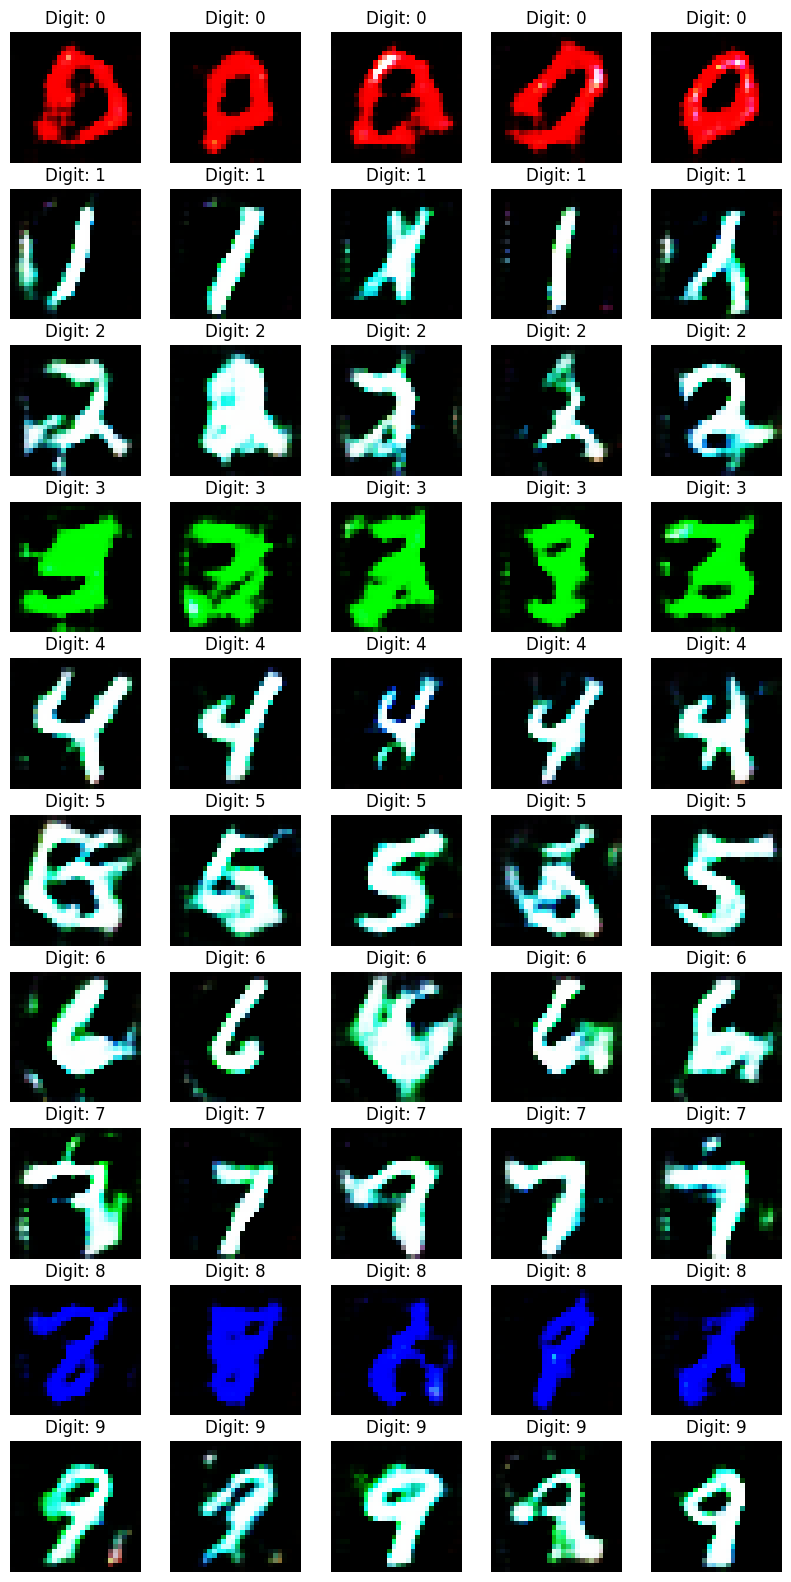

언러닝 전후 각 클래스별 R 채널 평균값:
클래스 0: 언러닝 전 = 0.748605, 언러닝 후 = 0.820933, 차이 = -0.072328
클래스 1: 언러닝 전 = 0.461050, 언러닝 후 = 0.241994, 차이 = 0.219055
클래스 2: 언러닝 전 = 0.496503, 언러닝 후 = 0.280240, 차이 = 0.216263
클래스 3: 언러닝 전 = 0.002272, 언러닝 후 = 0.006939, 차이 = -0.004666
클래스 4: 언러닝 전 = 0.501867, 언러닝 후 = 0.260021, 차이 = 0.241846
클래스 5: 언러닝 전 = 0.506931, 언러닝 후 = 0.285130, 차이 = 0.221801
클래스 6: 언러닝 전 = 0.538464, 언러닝 후 = 0.267464, 차이 = 0.271001
클래스 7: 언러닝 전 = 0.526965, 언러닝 후 = 0.233689, 차이 = 0.293276
클래스 8: 언러닝 전 = 0.004056, 언러닝 후 = 0.001922, 차이 = 0.002134
클래스 9: 언러닝 전 = 0.499566, 언러닝 후 = 0.238790, 차이 = 0.260776


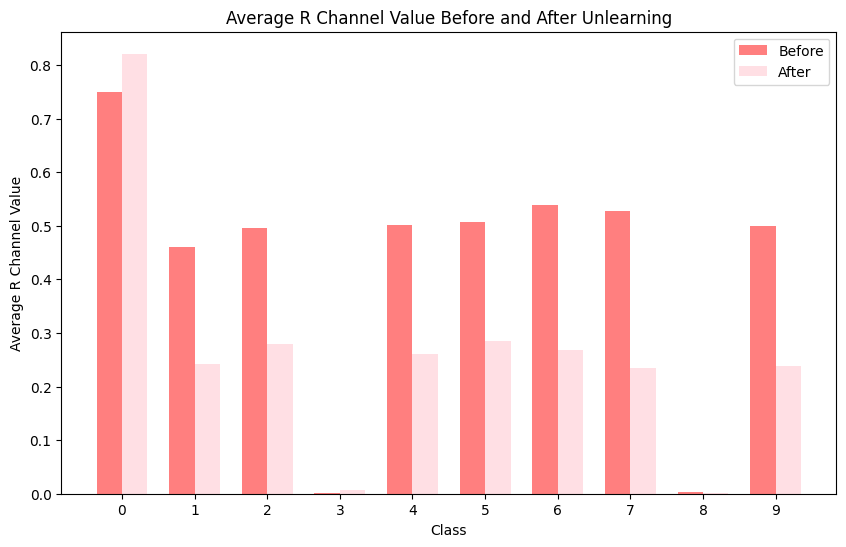

In [60]:
# Checkpoint를 통해 generator와 discriminator 모델 복원
ckpt.restore(tf.train.latest_checkpoint('checkpoints')).expect_partial()

forget_label = [0]
all_labels = np.argmax(y_train, axis=1)

# 잊을 샘플과 레이블
forget_indices = np.where(np.isin(all_labels, forget_label))[0]
forget_samples = X_train[forget_indices]
forget_labels = all_labels[forget_indices]

# 유지할 샘플과 레이블 (forget_label 제외)
retain_indices = np.where(~np.isin(all_labels, forget_label))[0]
retain_samples = X_train[retain_indices]
retain_labels = all_labels[retain_indices]

apply_unlearning(generator, forget_samples, retain_samples, forget_labels, retain_labels)

generate_and_save_images_after_unlearning(generator)

compare_red_pixels()

Epoch 0, Positive Loss: 0.3572496771812439, Negative Loss: 0.8628444075584412, Total Loss: 65.0705795288086
Epoch 10, Positive Loss: 0.3578999638557434, Negative Loss: 0.8627539277076721, Total Loss: 65.06444549560547
Epoch 20, Positive Loss: 0.3674195110797882, Negative Loss: 0.8611042499542236, Total Loss: 64.95023345947266
Epoch 30, Positive Loss: 0.36882102489471436, Negative Loss: 0.8582256436347961, Total Loss: 64.7357406616211
Epoch 40, Positive Loss: 0.3541271984577179, Negative Loss: 0.8608185052871704, Total Loss: 64.91551208496094
Epoch 50, Positive Loss: 0.3626968264579773, Negative Loss: 0.8599817752838135, Total Loss: 64.861328125
Epoch 60, Positive Loss: 0.3531794846057892, Negative Loss: 0.8581172227859497, Total Loss: 64.71197509765625
Epoch 70, Positive Loss: 0.38074058294296265, Negative Loss: 0.8611151576042175, Total Loss: 64.96437072753906
Epoch 80, Positive Loss: 0.35500383377075195, Negative Loss: 0.8584109544754028, Total Loss: 64.73582458496094
Epoch 90, Posit

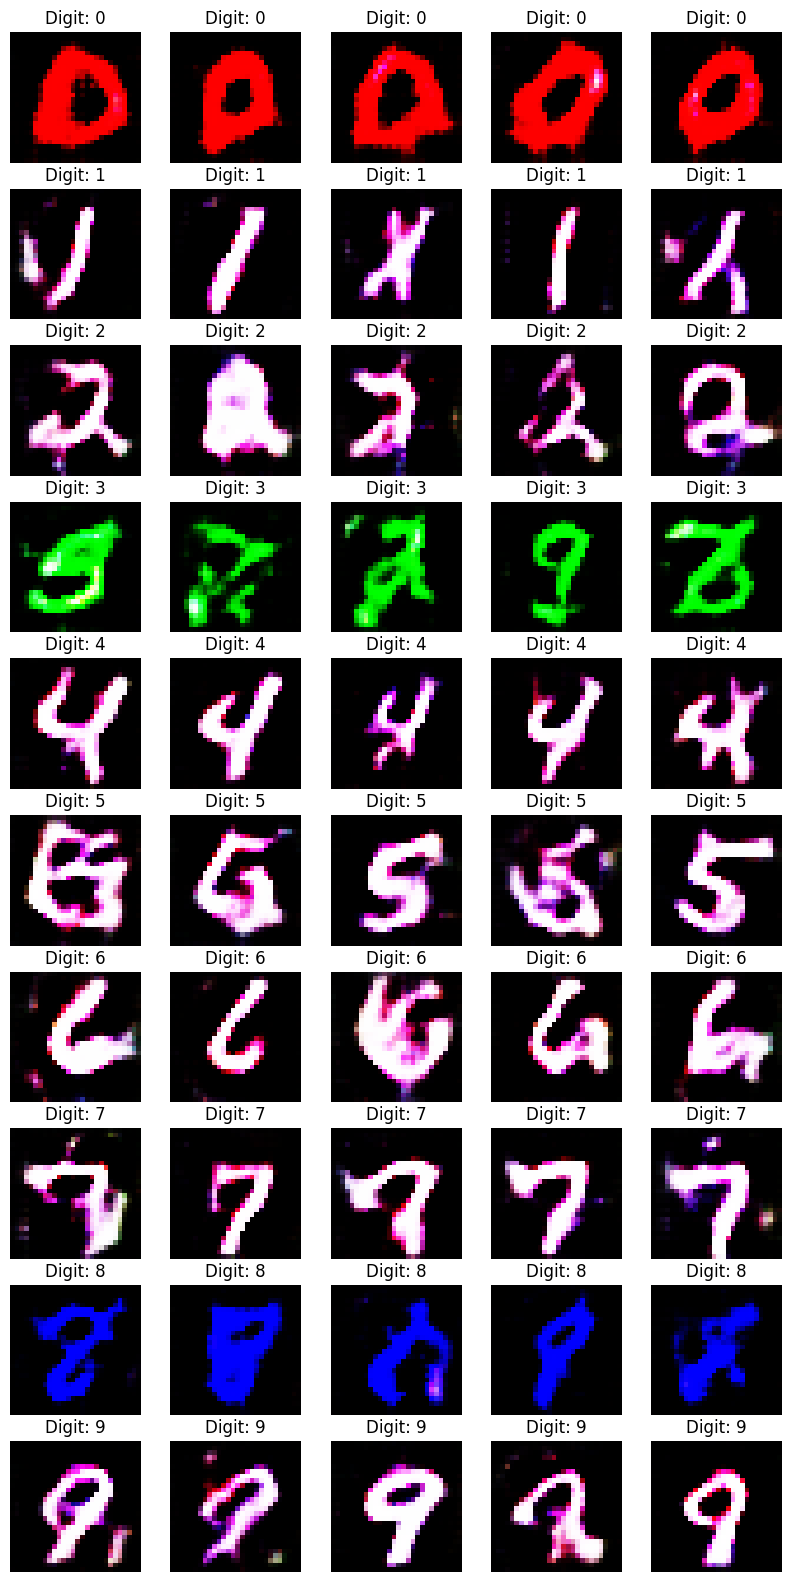

언러닝 전후 각 클래스별 G 채널 평균값:
클래스 0: 언러닝 전 = 0.003786, 언러닝 후 = 0.004623, 차이 = -0.000837
클래스 1: 언러닝 전 = 0.504867, 언러닝 후 = 0.218546, 차이 = 0.286321
클래스 2: 언러닝 전 = 0.478364, 언러닝 후 = 0.258234, 차이 = 0.220130
클래스 3: 언러닝 전 = 0.823737, 언러닝 후 = 0.815271, 차이 = 0.008466
클래스 4: 언러닝 전 = 0.425054, 언러닝 후 = 0.254994, 차이 = 0.170060
클래스 5: 언러닝 전 = 0.433577, 언러닝 후 = 0.285601, 차이 = 0.147976
클래스 6: 언러닝 전 = 0.442654, 언러닝 후 = 0.278326, 차이 = 0.164328
클래스 7: 언러닝 전 = 0.421470, 언러닝 후 = 0.256234, 차이 = 0.165235
클래스 8: 언러닝 전 = 0.002175, 언러닝 후 = 0.002677, 차이 = -0.000502
클래스 9: 언러닝 전 = 0.426884, 언러닝 후 = 0.236667, 차이 = 0.190217


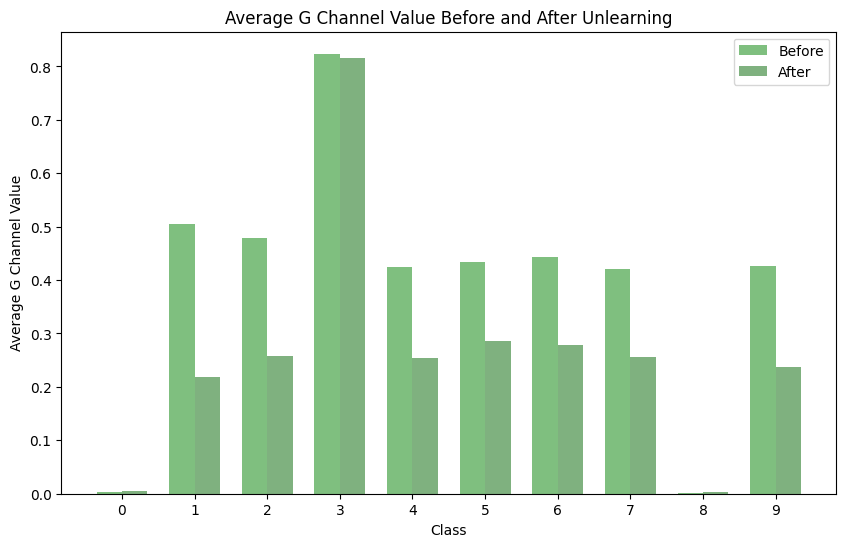

In [56]:
# Checkpoint를 통해 generator와 discriminator 모델 복원
ckpt.restore(tf.train.latest_checkpoint('checkpoints')).expect_partial()

forget_label = 3
all_labels = np.argmax(y_train, axis=1)

# 잊을 샘플과 레이블
forget_indices = np.where(all_labels == forget_label)[0]
forget_samples = X_train[forget_indices]
forget_labels = all_labels[forget_indices]

# 유지할 샘플과 레이블 (forget_label 제외)
retain_indices = np.where(all_labels != forget_label)[0]
retain_samples = X_train[retain_indices]
retain_labels = all_labels[retain_indices]

apply_unlearning(generator, forget_samples, retain_samples, forget_labels, retain_labels)

generate_and_save_images_after_unlearning(generator)

compare_green_pixels()

Epoch 0, Positive Loss: 0.3580768406391144, Negative Loss: 0.8650546073913574, Total Loss: 65.23717498779297
Epoch 10, Positive Loss: 0.3459165096282959, Negative Loss: 0.8591191172599792, Total Loss: 64.77985382080078
Epoch 20, Positive Loss: 0.3948218524456024, Negative Loss: 0.8595303297042847, Total Loss: 64.8595962524414
Epoch 30, Positive Loss: 0.33059510588645935, Negative Loss: 0.8609815835952759, Total Loss: 64.90421295166016
Epoch 40, Positive Loss: 0.37310487031936646, Negative Loss: 0.8581739068031311, Total Loss: 64.73615264892578
Epoch 50, Positive Loss: 0.3527399003505707, Negative Loss: 0.860275149345398, Total Loss: 64.87337493896484
Epoch 60, Positive Loss: 0.35312700271606445, Negative Loss: 0.858569860458374, Total Loss: 64.74586486816406
Epoch 70, Positive Loss: 0.3523445427417755, Negative Loss: 0.8564857244491577, Total Loss: 64.58877563476562
Epoch 80, Positive Loss: 0.34252822399139404, Negative Loss: 0.8567768335342407, Total Loss: 64.60079193115234
Epoch 90, 

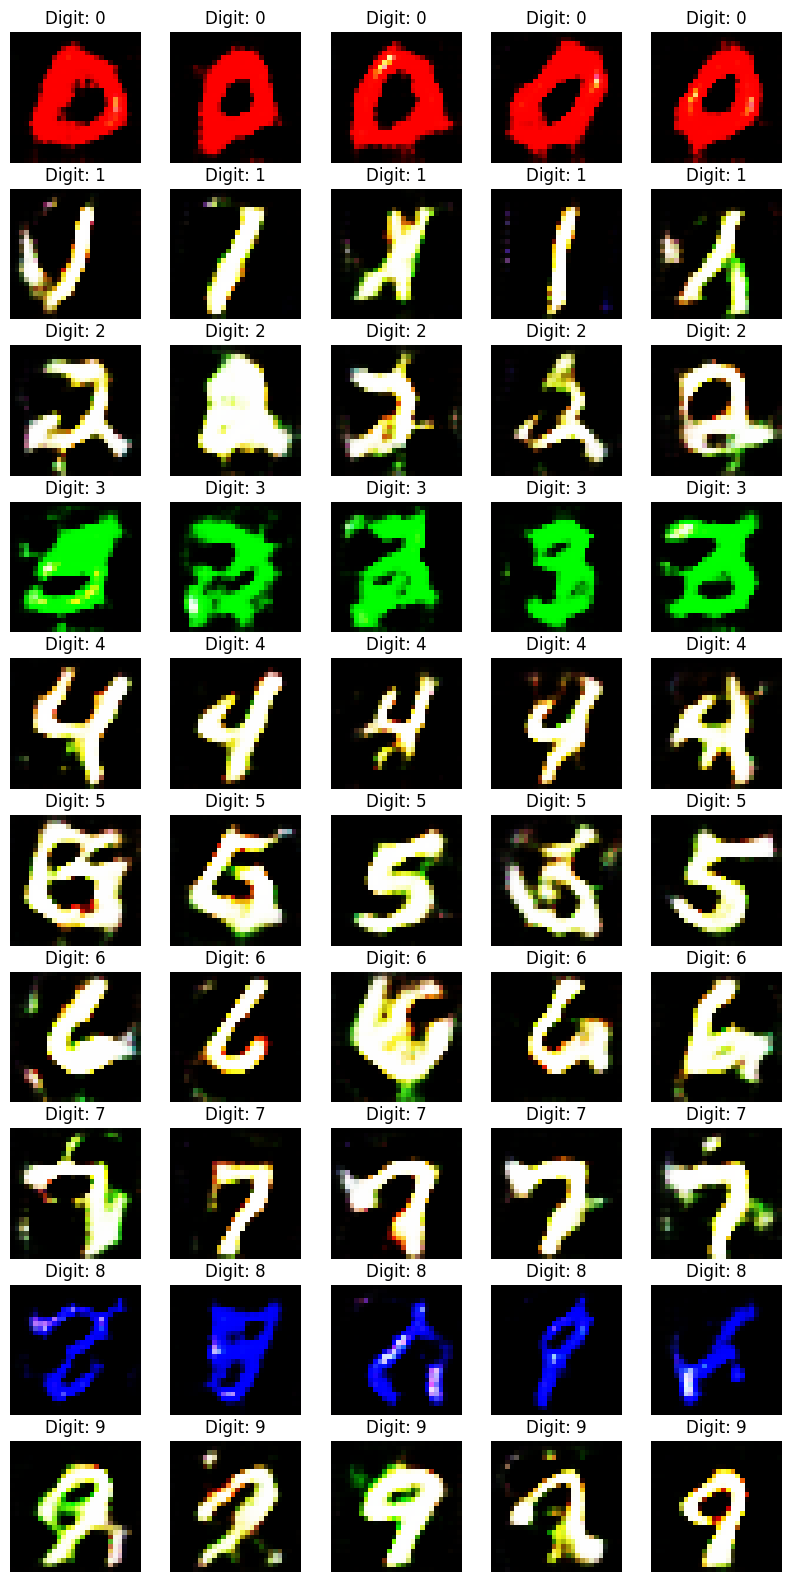

언러닝 전후 각 클래스별 B 채널 평균값:
클래스 0: 언러닝 전 = 0.004122, 언러닝 후 = 0.005638, 차이 = -0.001516
클래스 1: 언러닝 전 = 0.415515, 언러닝 후 = 0.252783, 차이 = 0.162732
클래스 2: 언러닝 전 = 0.400346, 언러닝 후 = 0.298059, 차이 = 0.102287
클래스 3: 언러닝 전 = 0.004287, 언러닝 후 = 0.014095, 차이 = -0.009809
클래스 4: 언러닝 전 = 0.422292, 언러닝 후 = 0.259439, 차이 = 0.162853
클래스 5: 언러닝 전 = 0.416923, 언러닝 후 = 0.286108, 차이 = 0.130816
클래스 6: 언러닝 전 = 0.497553, 언러닝 후 = 0.264681, 차이 = 0.232872
클래스 7: 언러닝 전 = 0.394566, 언러닝 후 = 0.255561, 차이 = 0.139005
클래스 8: 언러닝 전 = 0.747841, 언러닝 후 = 0.751369, 차이 = -0.003529
클래스 9: 언러닝 전 = 0.512605, 언러닝 후 = 0.257845, 차이 = 0.254760


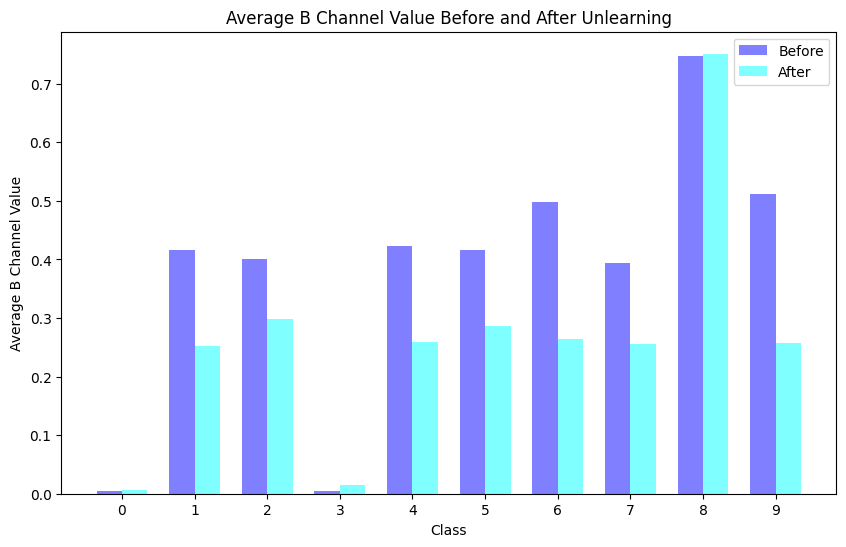

In [52]:
# Checkpoint를 통해 generator와 discriminator 모델 복원
ckpt.restore(tf.train.latest_checkpoint('checkpoints')).expect_partial()

forget_label = 8
all_labels = np.argmax(y_train, axis=1)

# 잊을 샘플과 레이블
forget_indices = np.where(all_labels == forget_label)[0]
forget_samples = X_train[forget_indices]
forget_labels = all_labels[forget_indices]

# 유지할 샘플과 레이블 (forget_label 제외)
retain_indices = np.where(all_labels != forget_label)[0]
retain_samples = X_train[retain_indices]
retain_labels = all_labels[retain_indices]

apply_unlearning(generator, forget_samples, retain_samples, forget_labels, retain_labels)

generate_and_save_images_after_unlearning(generator)

compare_blue_pixels()